In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Skull Stripping

In [ ]:
import os
import cv2

# Input and output folders
input_folder = "/content/gdrive/MyDrive/Brain Tumor/Testing/pituitary"  # Replace with the path to your JPEG image folder
output_folder = "/content/gdrive/MyDrive/Brain Tumor/Testing/skull_stripped_pituitary"  # Replace with the path where you want to save stripped images

# Ensure the output folder exists
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# List all files in the input folder
input_files = os.listdir(input_folder)

# Skull stripping process
for input_file in input_files:
    if input_file.endswith(".jpg"):
        input_path = os.path.join(input_folder, input_file)
        output_path = os.path.join(output_folder, input_file)

        # Load the image using OpenCV
        image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)

        # Thresholding operation
        threshold_value = 100  # Adjust the threshold value as needed
        _, binary_image = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)

        # Save the stripped image
        cv2.imwrite(output_path, binary_image)

        print(f"Skull stripped image saved to {output_path}")

print("Skull stripping process completed.")


Model definition

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Concatenate, Dense, Dropout, Flatten, Input,Conv2D,MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.activations import softmax

# main CNN model - CNN1
main_model = Sequential()
main_model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(128, 128, 3)))
main_model.add(MaxPooling2D(pool_size=(2, 2)))

main_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
main_model.add(MaxPooling2D(pool_size=(2, 2)))



main_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
main_model.add(MaxPooling2D(pool_size=(2, 2)))

main_model.add(Flatten())

# lower features model - CNN2
lower_model1 = Sequential()
lower_model1.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(128, 128, 3)))
lower_model1.add(MaxPooling2D(pool_size=(2, 2)))
lower_model1.add(Flatten())

# lower features model - CNN3
lower_model2 = Sequential()
lower_model2.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(128, 128, 3)))
lower_model2.add(MaxPooling2D(pool_size=(2, 2)))
lower_model2.add(Flatten())

# Concatenate the outputs of the three models
merged_model = Concatenate()([main_model.output, lower_model1.output, lower_model2.output])

# Add a Flatten layer before passing to MultiHeadAttention
merged_model = Flatten()(merged_model)

# Attention Mechanism
class CustomMultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim):
        super(CustomMultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.query_dense = tf.keras.layers.Dense(units=self.key_dim)
        self.value_dense = tf.keras.layers.Dense(units=self.key_dim)

    def call(self, inputs):
        query, value = inputs[0], inputs[1]
        query = tf.keras.layers.Reshape((-1, self.key_dim))(query)
        value = tf.keras.layers.Reshape((-1, self.key_dim))(value)
        query = self.query_dense(query)
        value = self.value_dense(value)
        attention_weights = tf.keras.layers.Dot(axes=1)([query, value])
        attention_weights = tf.keras.layers.Activation('softmax')(attention_weights)
        return attention_weights


# Modify the attention layer output shape
attention_layer = CustomMultiHeadAttention(num_heads=4, key_dim=2)
attention_output = attention_layer([merged_model, merged_model])

# Flatten the attention output to match the shape of merged_model
attention_output = Flatten()(attention_output)

# Concatenate the attention output with the merged_model
merged_model_with_attention = Concatenate()([merged_model, attention_output])

# Modify the final dense layer input shape
final_model = Sequential()
final_model.add(Dense(64, activation='relu'))
final_model.add(Dropout(0.5))
final_model.add(Dense(1, activation='sigmoid'))

# Create a model that includes all three models
final_model = Model(inputs=[main_model.input, lower_model1.input, lower_model2.input], outputs=final_model(merged_model_with_attention))
final_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
final_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 conv2d_input (InputLayer)   [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 126, 126, 32)         896       ['conv2d_input[0][0]']        
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 61, 61, 32)           9248      ['max_pooling2d[0][0]']   

Loading Images function

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

def load_and_preprocess_images(folder, label):
    images = []
    labels = []

    for filename in os.listdir(folder):
        if filename.endswith(".jpg"):
            image = cv2.imread(os.path.join(folder, filename))
            if image is not None:
                resized_image = cv2.resize(image, (128, 128))
                images.append(resized_image)
                labels.append(label)

    return np.array(images), np.array(labels)


Training Matrix Function

In [ ]:
def plot_training_history(history):
    # Training and Validation Performance Graph
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.show()

    # Epoch vs Error Graph
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Over Epochs')
    plt.show()

    # Print metrics
    print("Final Training Accuracy:", history.history['accuracy'][-1])
    print("Final Training Loss:", history.history['loss'][-1])
    print("Final Validation Accuracy:", history.history['val_accuracy'][-1])
    print("Final Validation Loss:", history.history['val_loss'][-1])



Testing Matrix Function

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, roc_curve, roc_auc_score,confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels

def evaluate_model(model, test_images, test_labels, classes=None):
    # Evaluate on Testing Set
    test_loss, test_acc = model.evaluate([test_images, test_images, test_images], test_labels)
    print("Testing Loss:", test_loss)
    print("Testing Accuracy:", test_acc)

    # Make predictions on the testing set
    predictions = model.predict([test_images, test_images, test_images])

    # Convert predictions to binary values (0 or 1)
    binary_predictions = np.round(predictions)

    # Precision, Recall, F1 Score
    precision = precision_score(test_labels, binary_predictions)
    recall = recall_score(test_labels, binary_predictions)
    f1 = f1_score(test_labels, binary_predictions)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    # Confusion Matrix
    if classes is not None:
      cm = confusion_matrix(test_labels, binary_predictions)
      disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
      disp.plot()
      plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(test_labels, predictions)
    roc_auc = roc_auc_score(test_labels, predictions)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()




Class : Glioma & Meningioma

Epoch 1/10
67/67 [==============================] - 192s 3s/step - loss: 0.7148 - accuracy: 0.7030 - val_loss: 0.4399 - val_accuracy: 0.7917
Epoch 2/10
67/67 [==============================] - 161s 2s/step - loss: 0.3452 - accuracy: 0.8548 - val_loss: 0.3468 - val_accuracy: 0.8480
Epoch 3/10
67/67 [==============================] - 172s 3s/step - loss: 0.2251 - accuracy: 0.9074 - val_loss: 0.3768 - val_accuracy: 0.8480
Epoch 4/10
67/67 [==============================] - 189s 3s/step - loss: 0.1470 - accuracy: 0.9408 - val_loss: 0.3452 - val_accuracy: 0.8555
Epoch 5/10
67/67 [==============================] - 185s 3s/step - loss: 0.1055 - accuracy: 0.9582 - val_loss: 0.3592 - val_accuracy: 0.8668
Epoch 6/10
67/67 [==============================] - 181s 3s/step - loss: 0.0842 - accuracy: 0.9690 - val_loss: 0.3762 - val_accuracy: 0.8555
Epoch 7/10
67/67 [==============================] - 184s 3s/step - loss: 0.0622 - accuracy: 0.9751 - val_loss: 0.4129 - val_accuracy: 0.8555
Epoch 8/10
67

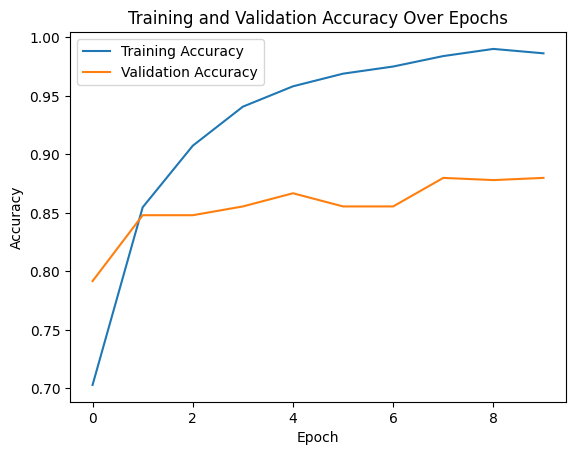

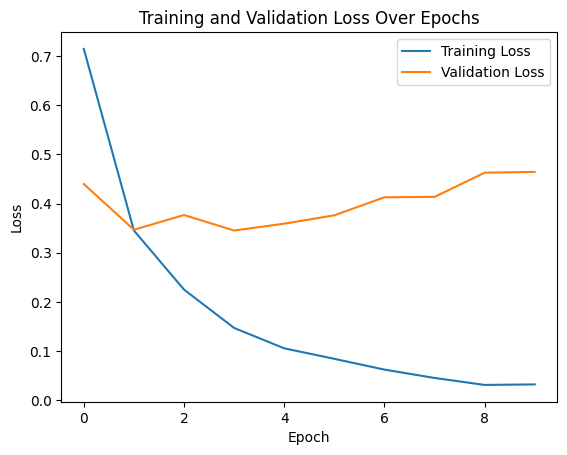

Final Training Accuracy: 0.986372172832489
Final Training Loss: 0.03209603205323219
Final Validation Accuracy: 0.8799249529838562
Final Validation Loss: 0.46461641788482666
19/19 [==============================] - 13s 673ms/step - loss: 0.3811 - accuracy: 0.8993
Testing Loss: 0.3810890018939972
Testing Accuracy: 0.8993399143218994
19/19 [==============================] - 14s 713ms/step
Precision: 0.9222614840989399
Recall: 0.87
F1 Score: 0.895368782161235


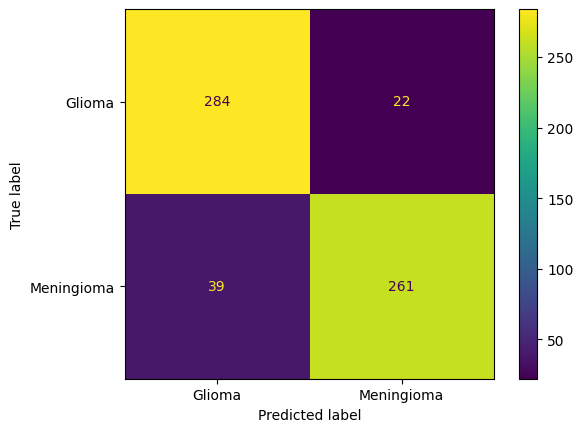

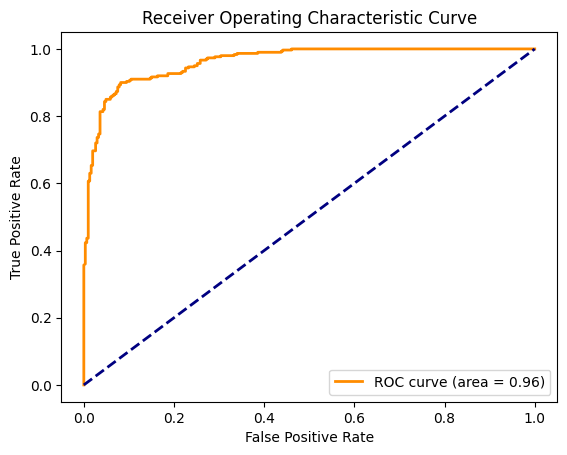

In [ ]:
# Define the folders containing the images
yes_folder = "/content/gdrive/MyDrive/Brain Tumor/Training/skull_stripped_glioma"
no_folder = "/content/gdrive/MyDrive/Brain Tumor/Training/skull_stripped_meningioma"

# Load and preprocess "yes" images
X_yes, y_yes = load_and_preprocess_images(yes_folder, 1)

# Load and preprocess "no" images
X_no, y_no = load_and_preprocess_images(no_folder, 0)

# Concatenate the data
X_train = np.concatenate([X_yes, X_no])
y_train = np.concatenate([y_yes, y_no])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Normalize pixel values to be between 0 and 1
X_train_normalized = X_train / 255.0
X_val_normalized = X_val / 255.0

# Define the folders containing the testing images
test_yes_folder = "/content/gdrive/MyDrive/Brain Tumor/Testing/skull_stripped_glioma"
test_no_folder = "/content/gdrive/MyDrive/Brain Tumor/Testing/skull_stripped_meningioma"

# Load and preprocess "yes" testing images
test_images_yes, test_labels_yes = load_and_preprocess_images(test_yes_folder, 1)

# Load and preprocess "no" testing images
test_images_no, test_labels_no = load_and_preprocess_images(test_no_folder, 0)

# Concatenate the testing data
test_images = np.concatenate([test_images_yes, test_images_no])
test_labels = np.concatenate([test_labels_yes, test_labels_no])

# Normalize pixel values to be between 0 and 1
test_images_normalized = test_images / 255.0

# Train the model
history = final_model.fit([X_train_normalized, X_train_normalized, X_train_normalized], y_train, epochs=10, validation_data=([X_val_normalized, X_val_normalized, X_val_normalized], y_val))
final_model.evaluate([X_val_normalized, X_val_normalized, X_val_normalized], y_val)
# Use the function
plot_training_history(history)
# Use the function
evaluate_model(final_model, test_images_normalized, test_labels, classes=['Glioma', 'Meningioma'])


Glioma & Notumor

Epoch 1/10
73/73 [==============================] - 209s 3s/step - loss: 0.6311 - accuracy: 0.9040 - val_loss: 0.0849 - val_accuracy: 0.9692
Epoch 2/10
73/73 [==============================] - 205s 3s/step - loss: 0.0760 - accuracy: 0.9756 - val_loss: 0.0549 - val_accuracy: 0.9846
Epoch 3/10
73/73 [==============================] - 215s 3s/step - loss: 0.0534 - accuracy: 0.9850 - val_loss: 0.0564 - val_accuracy: 0.9846
Epoch 4/10
73/73 [==============================] - 170s 2s/step - loss: 0.0272 - accuracy: 0.9923 - val_loss: 0.0458 - val_accuracy: 0.9897
Epoch 5/10
73/73 [==============================] - 180s 2s/step - loss: 0.0214 - accuracy: 0.9936 - val_loss: 0.0574 - val_accuracy: 0.9829
Epoch 6/10
73/73 [==============================] - 188s 3s/step - loss: 0.0110 - accuracy: 0.9987 - val_loss: 0.0537 - val_accuracy: 0.9914
Epoch 7/10
73/73 [==============================] - 184s 3s/step - loss: 0.0118 - accuracy: 0.9961 - val_loss: 0.0511 - val_accuracy: 0.9914
Epoch 8/10
73

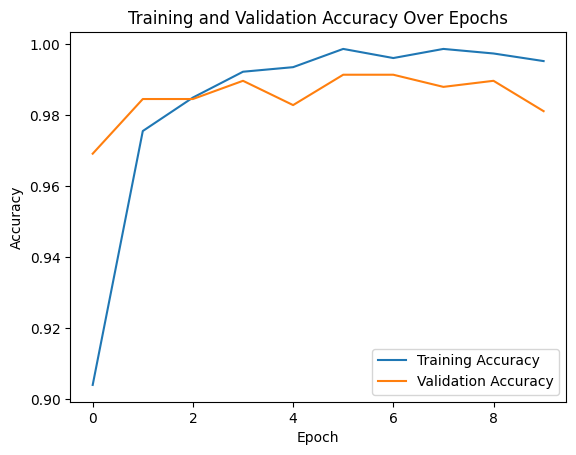

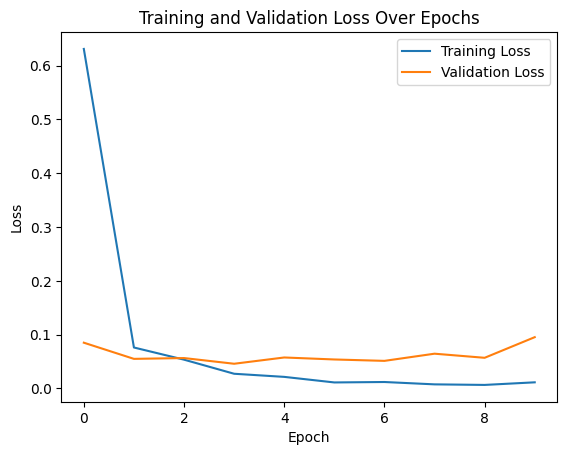

Final Training Accuracy: 0.9952850341796875
Final Training Loss: 0.011238890700042248
Final Validation Accuracy: 0.9811643958091736
Final Validation Loss: 0.09519175440073013
23/23 [==============================] - 13s 581ms/step - loss: 0.0548 - accuracy: 0.9858
Testing Loss: 0.05484646558761597
Testing Accuracy: 0.9858155846595764
23/23 [==============================] - 15s 637ms/step
Precision: 0.9931972789115646
Recall: 0.9733333333333334
F1 Score: 0.9831649831649831


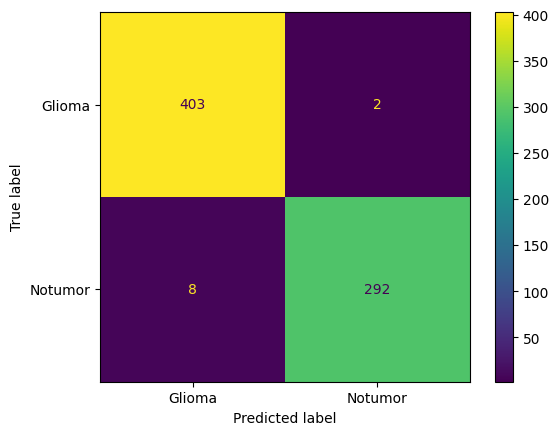

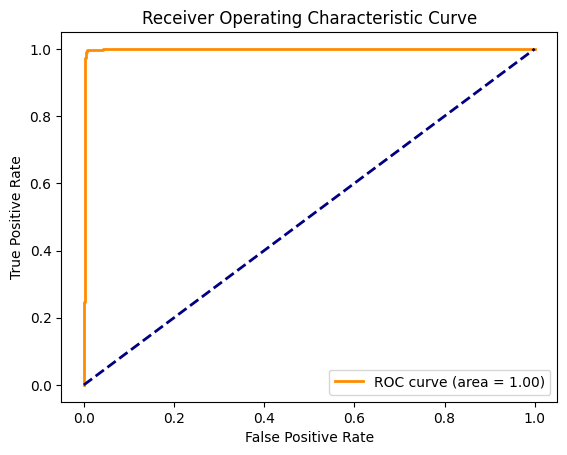

In [ ]:
# Define the folders containing the images
yes_folder = "/content/gdrive/MyDrive/Brain Tumor/Training/skull_stripped_glioma"
no_folder = "/content/gdrive/MyDrive/Brain Tumor/Training/skull_stripped_notumor"

# Load and preprocess "yes" images
X_yes, y_yes = load_and_preprocess_images(yes_folder, 1)

# Load and preprocess "no" images
X_no, y_no = load_and_preprocess_images(no_folder, 0)

# Concatenate the data
X_train = np.concatenate([X_yes, X_no])
y_train = np.concatenate([y_yes, y_no])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Normalize pixel values to be between 0 and 1
X_train_normalized = X_train / 255.0
X_val_normalized = X_val / 255.0

# Define the folders containing the testing images
test_yes_folder = "/content/gdrive/MyDrive/Brain Tumor/Testing/skull_stripped_glioma"
test_no_folder = "/content/gdrive/MyDrive/Brain Tumor/Testing/skull_stripped_notumor"

# Load and preprocess "yes" testing images
test_images_yes, test_labels_yes = load_and_preprocess_images(test_yes_folder, 1)

# Load and preprocess "no" testing images
test_images_no, test_labels_no = load_and_preprocess_images(test_no_folder, 0)

# Concatenate the testing data
test_images = np.concatenate([test_images_yes, test_images_no])
test_labels = np.concatenate([test_labels_yes, test_labels_no])

# Normalize pixel values to be between 0 and 1
test_images_normalized = test_images / 255.0

# Train the model
history = final_model.fit([X_train_normalized, X_train_normalized, X_train_normalized], y_train, epochs=10, validation_data=([X_val_normalized, X_val_normalized, X_val_normalized], y_val))
final_model.evaluate([X_val_normalized, X_val_normalized, X_val_normalized], y_val)
# Use the function
plot_training_history(history)
# Use the function
evaluate_model(final_model, test_images_normalized, test_labels, classes=['Glioma', 'Notumor'])


Glioma & Pituitary

Epoch 1/10
71/71 [==============================] - 202s 3s/step - loss: 0.2214 - accuracy: 0.9259 - val_loss: 0.1106 - val_accuracy: 0.9681
Epoch 2/10
71/71 [==============================] - 189s 3s/step - loss: 0.0725 - accuracy: 0.9752 - val_loss: 0.0855 - val_accuracy: 0.9805
Epoch 3/10
71/71 [==============================] - 178s 3s/step - loss: 0.0316 - accuracy: 0.9880 - val_loss: 0.0720 - val_accuracy: 0.9823
Epoch 4/10
71/71 [==============================] - 188s 3s/step - loss: 0.0197 - accuracy: 0.9902 - val_loss: 0.0804 - val_accuracy: 0.9823
Epoch 5/10
71/71 [==============================] - 187s 3s/step - loss: 0.0168 - accuracy: 0.9911 - val_loss: 0.0944 - val_accuracy: 0.9805
Epoch 6/10
71/71 [==============================] - 197s 3s/step - loss: 0.0188 - accuracy: 0.9898 - val_loss: 0.0884 - val_accuracy: 0.9858
Epoch 7/10
71/71 [==============================] - 192s 3s/step - loss: 0.0143 - accuracy: 0.9920 - val_loss: 0.1184 - val_accuracy: 0.9787
Epoch 8/10
71

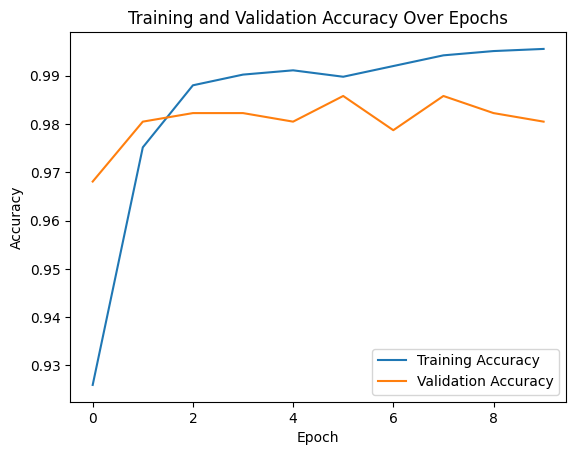

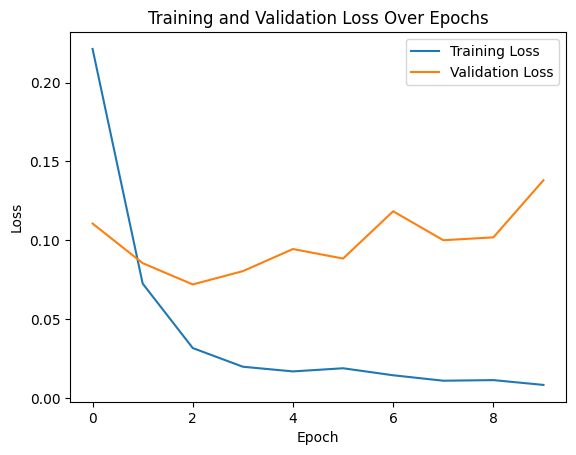

Final Training Accuracy: 0.9955654144287109
Final Training Loss: 0.008211097680032253
Final Validation Accuracy: 0.9804964661598206
Final Validation Loss: 0.13807633519172668
19/19 [==============================] - 14s 760ms/step - loss: 0.0567 - accuracy: 0.9800
Testing Loss: 0.05673222988843918
Testing Accuracy: 0.9800000190734863
19/19 [==============================] - 14s 720ms/step
Precision: 0.9705882352941176
Recall: 0.99
F1 Score: 0.9801980198019802


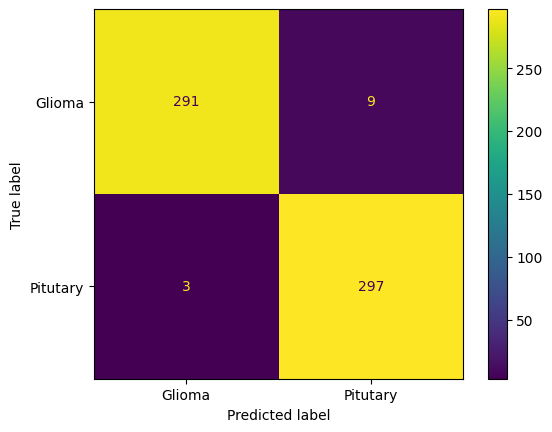

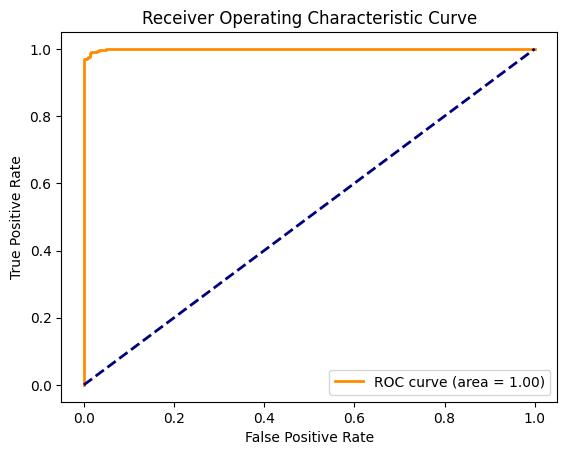

In [ ]:
# Define the folders containing the images
yes_folder = "/content/gdrive/MyDrive/Brain Tumor/Training/skull_stripped_glioma"
no_folder = "/content/gdrive/MyDrive/Brain Tumor/Training/skull_stripped_pituitary"

# Load and preprocess "yes" images
X_yes, y_yes = load_and_preprocess_images(yes_folder, 1)

# Load and preprocess "no" images
X_no, y_no = load_and_preprocess_images(no_folder, 0)

# Concatenate the data
X_train = np.concatenate([X_yes, X_no])
y_train = np.concatenate([y_yes, y_no])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Normalize pixel values to be between 0 and 1
X_train_normalized = X_train / 255.0
X_val_normalized = X_val / 255.0

# Define the folders containing the testing images
test_yes_folder = "/content/gdrive/MyDrive/Brain Tumor/Testing/skull_stripped_glioma"
test_no_folder = "/content/gdrive/MyDrive/Brain Tumor/Testing/skull_stripped_pituitary"

# Load and preprocess "yes" testing images
test_images_yes, test_labels_yes = load_and_preprocess_images(test_yes_folder, 1)

# Load and preprocess "no" testing images
test_images_no, test_labels_no = load_and_preprocess_images(test_no_folder, 0)

# Concatenate the testing data
test_images = np.concatenate([test_images_yes, test_images_no])
test_labels = np.concatenate([test_labels_yes, test_labels_no])

# Normalize pixel values to be between 0 and 1
test_images_normalized = test_images / 255.0

# Train the model
history = final_model.fit([X_train_normalized, X_train_normalized, X_train_normalized], y_train, epochs=10, validation_data=([X_val_normalized, X_val_normalized, X_val_normalized], y_val))
final_model.evaluate([X_val_normalized, X_val_normalized, X_val_normalized], y_val)
# Use the function
plot_training_history(history)
# Use the function
evaluate_model(final_model, test_images_normalized, test_labels, classes=['Glioma', 'Pitutary'])


Meningioma & Notumor

Epoch 1/10
74/74 [==============================] - 198s 3s/step - loss: 0.4971 - accuracy: 0.8308 - val_loss: 0.1652 - val_accuracy: 0.9353
Epoch 2/10
74/74 [==============================] - 189s 3s/step - loss: 0.1856 - accuracy: 0.9327 - val_loss: 0.1240 - val_accuracy: 0.9540
Epoch 3/10
74/74 [==============================] - 185s 2s/step - loss: 0.1202 - accuracy: 0.9510 - val_loss: 0.1249 - val_accuracy: 0.9506
Epoch 4/10
74/74 [==============================] - 197s 3s/step - loss: 0.0971 - accuracy: 0.9565 - val_loss: 0.0908 - val_accuracy: 0.9591
Epoch 5/10
74/74 [==============================] - 192s 3s/step - loss: 0.0705 - accuracy: 0.9702 - val_loss: 0.1010 - val_accuracy: 0.9659
Epoch 6/10
74/74 [==============================] - 195s 3s/step - loss: 0.0515 - accuracy: 0.9719 - val_loss: 0.0992 - val_accuracy: 0.9625
Epoch 7/10
74/74 [==============================] - 190s 3s/step - loss: 0.0532 - accuracy: 0.9744 - val_loss: 0.1080 - val_accuracy: 0.9659
Epoch 8/10
74

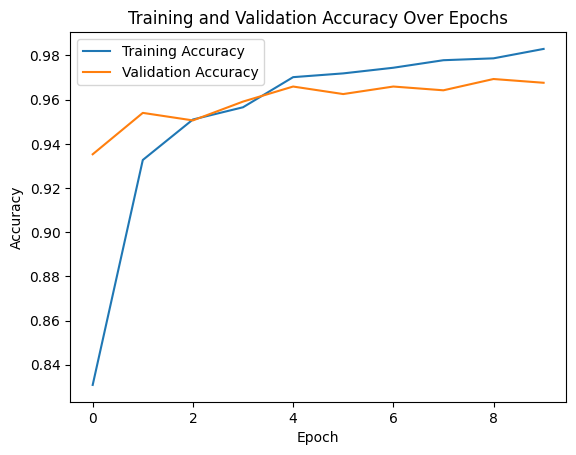

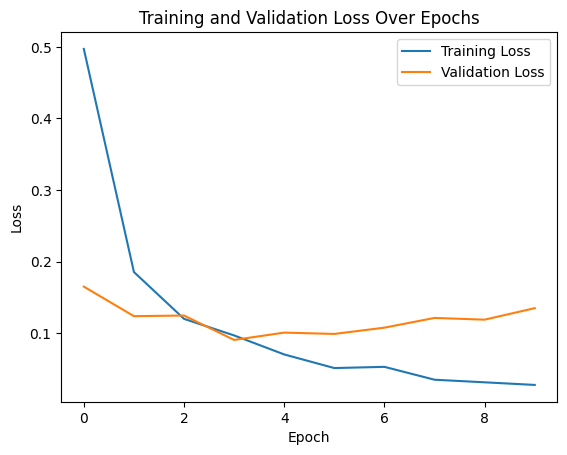

Final Training Accuracy: 0.9829569458961487
Final Training Loss: 0.028003713116049767
Final Validation Accuracy: 0.9676320552825928
Final Validation Loss: 0.135167196393013
23/23 [==============================] - 14s 589ms/step - loss: 0.1358 - accuracy: 0.9592
Testing Loss: 0.13580352067947388
Testing Accuracy: 0.9592123627662659
23/23 [==============================] - 13s 588ms/step
Precision: 0.9759450171821306
Recall: 0.9281045751633987
F1 Score: 0.9514237855946399


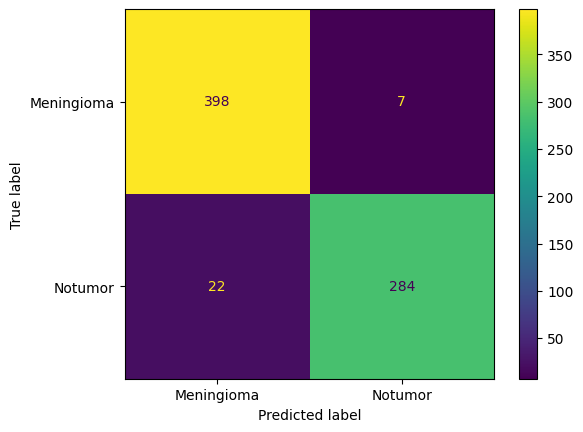

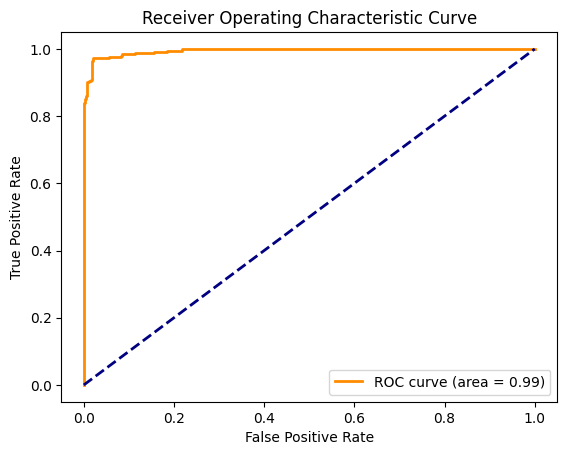

In [ ]:
# Define the folders containing the images
yes_folder = "/content/gdrive/MyDrive/Brain Tumor/Training/skull_stripped_meningioma"
no_folder = "/content/gdrive/MyDrive/Brain Tumor/Training/skull_stripped_notumor"

# Load and preprocess "yes" images
X_yes, y_yes = load_and_preprocess_images(yes_folder, 1)

# Load and preprocess "no" images
X_no, y_no = load_and_preprocess_images(no_folder, 0)

# Concatenate the data
X_train = np.concatenate([X_yes, X_no])
y_train = np.concatenate([y_yes, y_no])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Normalize pixel values to be between 0 and 1
X_train_normalized = X_train / 255.0
X_val_normalized = X_val / 255.0

# Define the folders containing the testing images
test_yes_folder = "/content/gdrive/MyDrive/Brain Tumor/Testing/skull_stripped_meningioma"
test_no_folder = "/content/gdrive/MyDrive/Brain Tumor/Testing/skull_stripped_notumor"

# Load and preprocess "yes" testing images
test_images_yes, test_labels_yes = load_and_preprocess_images(test_yes_folder, 1)

# Load and preprocess "no" testing images
test_images_no, test_labels_no = load_and_preprocess_images(test_no_folder, 0)

# Concatenate the testing data
test_images = np.concatenate([test_images_yes, test_images_no])
test_labels = np.concatenate([test_labels_yes, test_labels_no])

# Normalize pixel values to be between 0 and 1
test_images_normalized = test_images / 255.0

# Train the model
history = final_model.fit([X_train_normalized, X_train_normalized, X_train_normalized], y_train, epochs=10, validation_data=([X_val_normalized, X_val_normalized, X_val_normalized], y_val))
final_model.evaluate([X_val_normalized, X_val_normalized, X_val_normalized], y_val)
# Use the function
plot_training_history(history)
# Use the function
evaluate_model(final_model, test_images_normalized, test_labels, classes=['Meningioma', 'Notumor'])


Meningioma & Pituitary

Epoch 1/10
71/71 [==============================] - 188s 3s/step - loss: 0.3844 - accuracy: 0.8563 - val_loss: 0.1760 - val_accuracy: 0.9331
Epoch 2/10
71/71 [==============================] - 187s 3s/step - loss: 0.1551 - accuracy: 0.9299 - val_loss: 0.1312 - val_accuracy: 0.9489
Epoch 3/10
71/71 [==============================] - 174s 2s/step - loss: 0.0918 - accuracy: 0.9568 - val_loss: 0.0982 - val_accuracy: 0.9613
Epoch 4/10
71/71 [==============================] - 172s 2s/step - loss: 0.0715 - accuracy: 0.9744 - val_loss: 0.1077 - val_accuracy: 0.9630
Epoch 5/10
71/71 [==============================] - 185s 3s/step - loss: 0.0539 - accuracy: 0.9797 - val_loss: 0.1429 - val_accuracy: 0.9577
Epoch 6/10
71/71 [==============================] - 185s 3s/step - loss: 0.0370 - accuracy: 0.9881 - val_loss: 0.1155 - val_accuracy: 0.9648
Epoch 7/10
71/71 [==============================] - 188s 3s/step - loss: 0.0298 - accuracy: 0.9872 - val_loss: 0.1464 - val_accuracy: 0.9648
Epoch 8/10
71

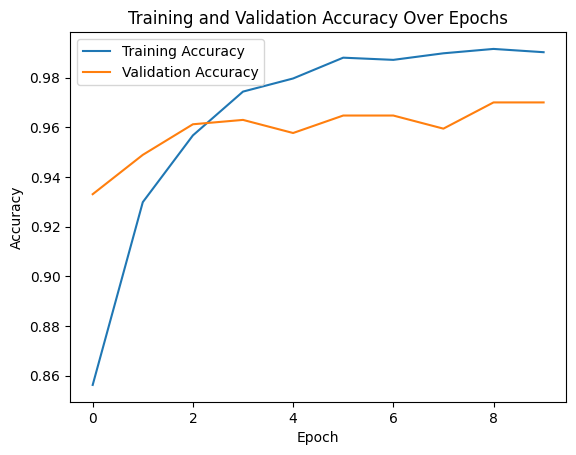

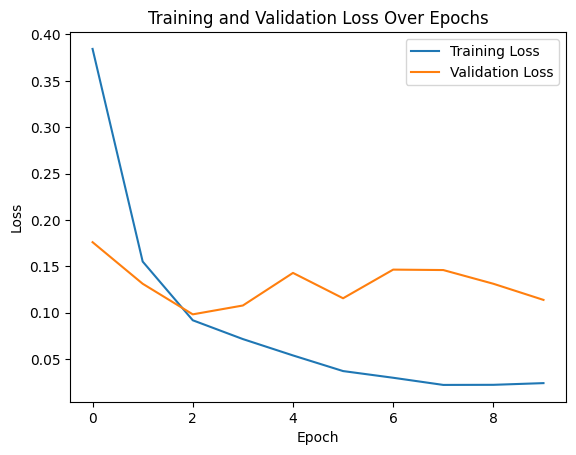

Final Training Accuracy: 0.9902998208999634
Final Training Loss: 0.024042680859565735
Final Validation Accuracy: 0.9700704216957092
Final Validation Loss: 0.11376810818910599
19/19 [==============================] - 13s 683ms/step - loss: 0.1419 - accuracy: 0.9587
Testing Loss: 0.14193308353424072
Testing Accuracy: 0.9587458968162537
19/19 [==============================] - 11s 560ms/step
Precision: 0.9730639730639731
Recall: 0.9444444444444444
F1 Score: 0.9585406301824213


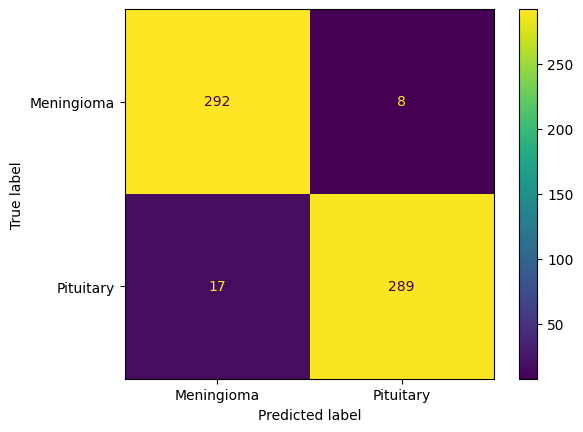

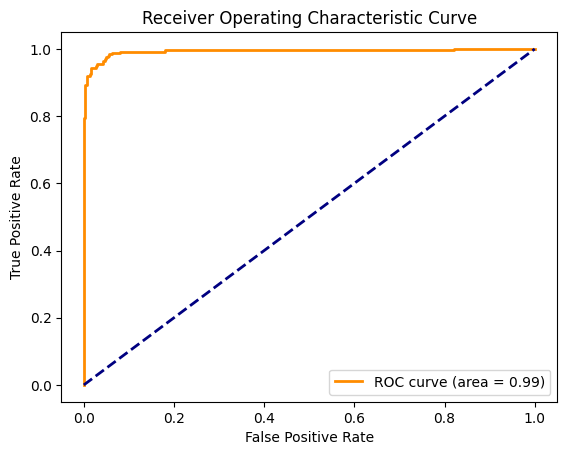

In [ ]:
# Define the folders containing the images
yes_folder = "/content/gdrive/MyDrive/Brain Tumor/Training/skull_stripped_meningioma"
no_folder = "/content/gdrive/MyDrive/Brain Tumor/Training/skull_stripped_pituitary"

# Load and preprocess "yes" images
X_yes, y_yes = load_and_preprocess_images(yes_folder, 1)

# Load and preprocess "no" images
X_no, y_no = load_and_preprocess_images(no_folder, 0)

# Concatenate the data
X_train = np.concatenate([X_yes, X_no])
y_train = np.concatenate([y_yes, y_no])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Normalize pixel values to be between 0 and 1
X_train_normalized = X_train / 255.0
X_val_normalized = X_val / 255.0

# Define the folders containing the testing images
test_yes_folder = "/content/gdrive/MyDrive/Brain Tumor/Testing/skull_stripped_meningioma"
test_no_folder = "/content/gdrive/MyDrive/Brain Tumor/Testing/skull_stripped_pituitary"

# Load and preprocess "yes" testing images
test_images_yes, test_labels_yes = load_and_preprocess_images(test_yes_folder, 1)

# Load and preprocess "no" testing images
test_images_no, test_labels_no = load_and_preprocess_images(test_no_folder, 0)

# Concatenate the testing data
test_images = np.concatenate([test_images_yes, test_images_no])
test_labels = np.concatenate([test_labels_yes, test_labels_no])

# Normalize pixel values to be between 0 and 1
test_images_normalized = test_images / 255.0

# Train the model
history = final_model.fit([X_train_normalized, X_train_normalized, X_train_normalized], y_train, epochs=10, validation_data=([X_val_normalized, X_val_normalized, X_val_normalized], y_val))
final_model.evaluate([X_val_normalized, X_val_normalized, X_val_normalized], y_val)
# Use the function
plot_training_history(history)
# Use the function
evaluate_model(final_model, test_images_normalized, test_labels, classes=['Meningioma', 'Pituitary'])


Notumor & Pituitary

Epoch 1/10
78/78 [==============================] - 197s 3s/step - loss: 0.2326 - accuracy: 0.9175 - val_loss: 0.0928 - val_accuracy: 0.9725
Epoch 2/10
78/78 [==============================] - 195s 3s/step - loss: 0.0785 - accuracy: 0.9652 - val_loss: 0.0777 - val_accuracy: 0.9790
Epoch 3/10
78/78 [==============================] - 202s 3s/step - loss: 0.0514 - accuracy: 0.9778 - val_loss: 0.0688 - val_accuracy: 0.9822
Epoch 4/10
78/78 [==============================] - 170s 2s/step - loss: 0.0426 - accuracy: 0.9798 - val_loss: 0.0738 - val_accuracy: 0.9838
Epoch 5/10
78/78 [==============================] - 180s 2s/step - loss: 0.0319 - accuracy: 0.9822 - val_loss: 0.0761 - val_accuracy: 0.9838
Epoch 6/10
78/78 [==============================] - 179s 2s/step - loss: 0.0275 - accuracy: 0.9838 - val_loss: 0.0835 - val_accuracy: 0.9838
Epoch 7/10
78/78 [==============================] - 181s 2s/step - loss: 0.0252 - accuracy: 0.9875 - val_loss: 0.0889 - val_accuracy: 0.9822
Epoch 8/10
78

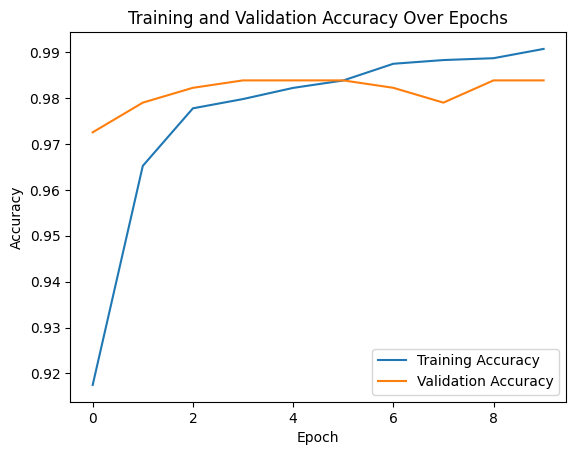

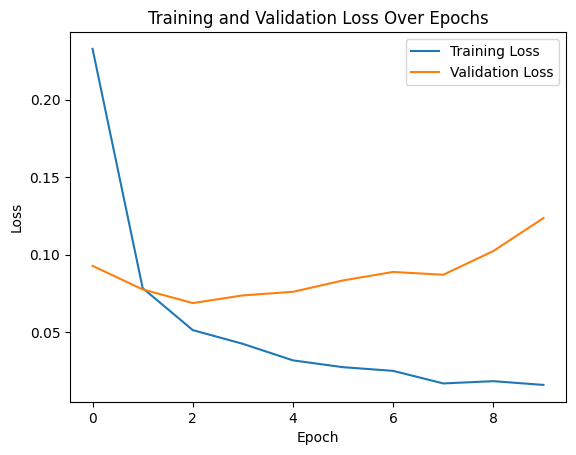

Final Training Accuracy: 0.9906995296478271
Final Training Loss: 0.01611611433327198
Final Validation Accuracy: 0.9838449358940125
Final Validation Loss: 0.12365899235010147
23/23 [==============================] - 11s 471ms/step - loss: 0.0374 - accuracy: 0.9887
Testing Loss: 0.03742029890418053
Testing Accuracy: 0.9886524677276611
23/23 [==============================] - 14s 576ms/step
Precision: 0.9925558312655087
Recall: 0.9876543209876543
F1 Score: 0.9900990099009901


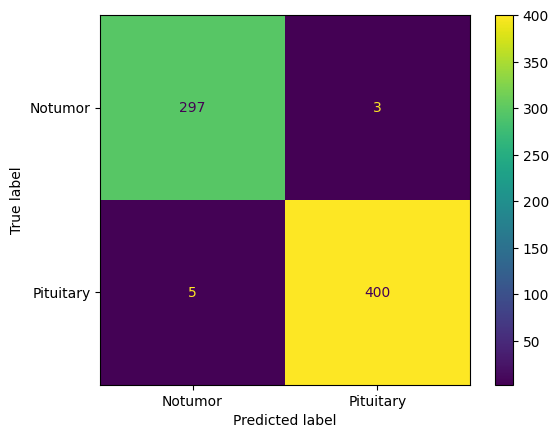

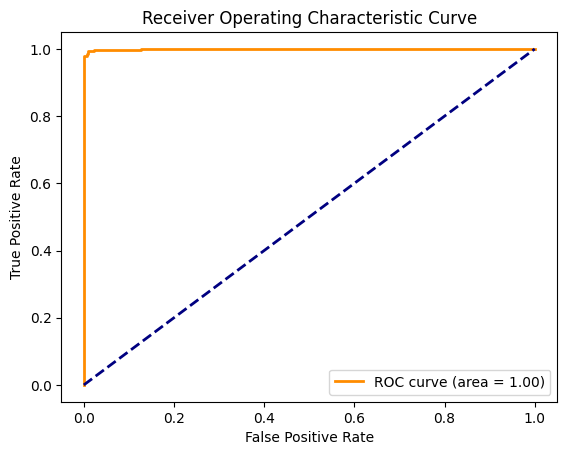

In [ ]:
# Define the folders containing the images
yes_folder = "/content/gdrive/MyDrive/Brain Tumor/Training/skull_stripped_notumor"
no_folder = "/content/gdrive/MyDrive/Brain Tumor/Training/skull_stripped_pituitary"

# Load and preprocess "yes" images
X_yes, y_yes = load_and_preprocess_images(yes_folder, 1)

# Load and preprocess "no" images
X_no, y_no = load_and_preprocess_images(no_folder, 0)

# Concatenate the data
X_train = np.concatenate([X_yes, X_no])
y_train = np.concatenate([y_yes, y_no])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Normalize pixel values to be between 0 and 1
X_train_normalized = X_train / 255.0
X_val_normalized = X_val / 255.0

# Define the folders containing the testing images
test_yes_folder = "/content/gdrive/MyDrive/Brain Tumor/Testing/skull_stripped_notumor"
test_no_folder = "/content/gdrive/MyDrive/Brain Tumor/Testing/skull_stripped_pituitary"

# Load and preprocess "yes" testing images
test_images_yes, test_labels_yes = load_and_preprocess_images(test_yes_folder, 1)

# Load and preprocess "no" testing images
test_images_no, test_labels_no = load_and_preprocess_images(test_no_folder, 0)

# Concatenate the testing data
test_images = np.concatenate([test_images_yes, test_images_no])
test_labels = np.concatenate([test_labels_yes, test_labels_no])

# Normalize pixel values to be between 0 and 1
test_images_normalized = test_images / 255.0

# Train the model
history = final_model.fit([X_train_normalized, X_train_normalized, X_train_normalized], y_train, epochs=10, validation_data=([X_val_normalized, X_val_normalized, X_val_normalized], y_val))
final_model.evaluate([X_val_normalized, X_val_normalized, X_val_normalized], y_val)
# Use the function
plot_training_history(history)
# Use the function
evaluate_model(final_model, test_images_normalized, test_labels, classes=['Notumor', 'Pituitary'])


Dataset 2

Epoch 1/10
57/57 [==============================] - 130s 2s/step - loss: 0.0517 - accuracy: 0.9840 - val_loss: 0.1868 - val_accuracy: 0.9321
Epoch 2/10
57/57 [==============================] - 121s 2s/step - loss: 0.0291 - accuracy: 0.9895 - val_loss: 0.2652 - val_accuracy: 0.9354
Epoch 3/10
57/57 [==============================] - 125s 2s/step - loss: 0.0268 - accuracy: 0.9912 - val_loss: 0.1793 - val_accuracy: 0.9470
Epoch 4/10
57/57 [==============================] - 120s 2s/step - loss: 0.0260 - accuracy: 0.9917 - val_loss: 0.1762 - val_accuracy: 0.9437
Epoch 5/10
57/57 [==============================] - 124s 2s/step - loss: 0.0274 - accuracy: 0.9912 - val_loss: 0.1903 - val_accuracy: 0.9470
Epoch 6/10
57/57 [==============================] - 121s 2s/step - loss: 0.0228 - accuracy: 0.9890 - val_loss: 0.1685 - val_accuracy: 0.9487
Epoch 7/10
57/57 [==============================] - 121s 2s/step - loss: 0.0173 - accuracy: 0.9939 - val_loss: 0.1975 - val_accuracy: 0.9437
Epoch 8/10
57

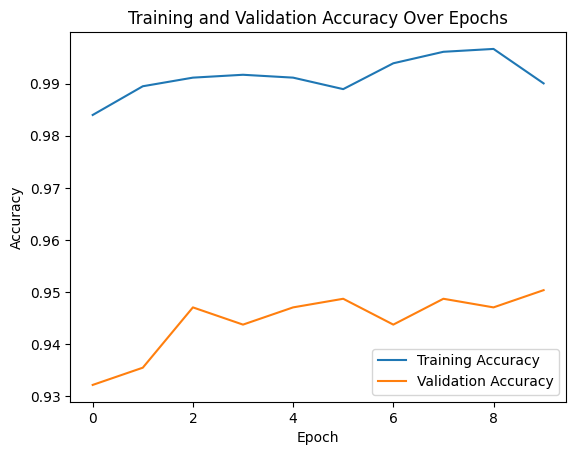

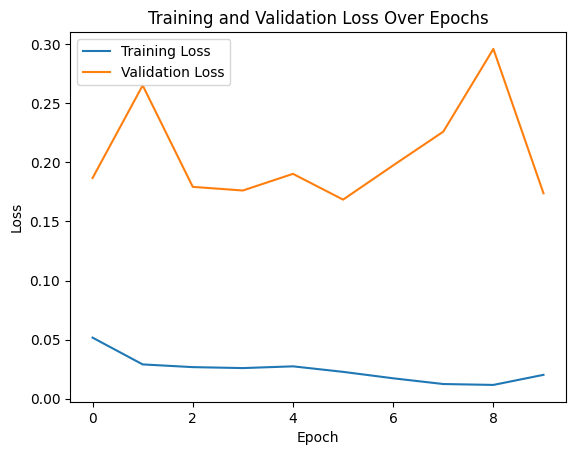

Final Training Accuracy: 0.9900662302970886
Final Training Loss: 0.02026197500526905
Final Validation Accuracy: 0.9503311514854431
Final Validation Loss: 0.17386826872825623
19/19 [==============================] - 11s 583ms/step - loss: 0.1535 - accuracy: 0.9586
Testing Loss: 0.15350568294525146
Testing Accuracy: 0.9586092829704285
19/19 [==============================] - 11s 575ms/step
Precision: 0.9929078014184397
Recall: 0.9240924092409241
F1 Score: 0.9572649572649572


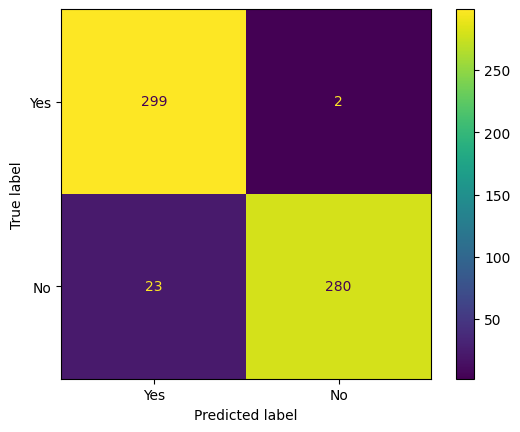

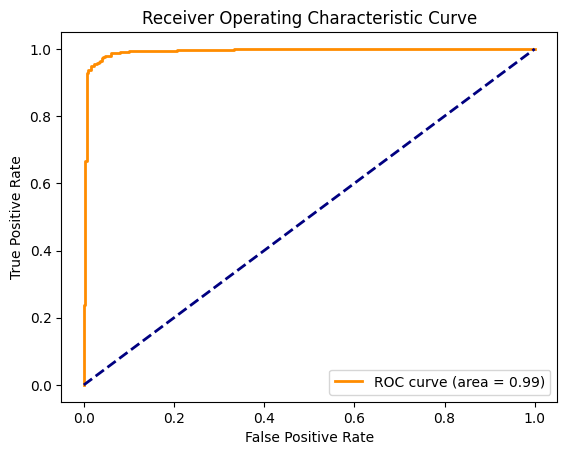

In [ ]:
# Define the folders containing the images
yes_folder = "/content/gdrive/MyDrive/BR35 H/skull_stripped_yes2"
no_folder = "/content/gdrive/MyDrive/BR35 H/skull_stripped_no"

# Load and preprocess "yes" images
X_yes, y_yes = load_and_preprocess_images(yes_folder, 1)

# Load and preprocess "no" images
X_no, y_no = load_and_preprocess_images(no_folder, 0)

# Concatenate the data
X_train = np.concatenate([X_yes, X_no])
y_train = np.concatenate([y_yes, y_no])

# Split the data into training and temporary set (combined validation and testing)
X_train, X_temp, y_train, y_temp = train_test_split(X_train, y_train, test_size=0.4, random_state=42)

# Split the temporary set into validation and testing
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize pixel values to be between 0 and 1
X_train_normalized = X_train / 255.0
X_val_normalized = X_val / 255.0
X_test_normalized = X_test / 255.0

# Train the model
history = final_model.fit([X_train_normalized, X_train_normalized, X_train_normalized], y_train, epochs=10, validation_data=([X_val_normalized, X_val_normalized, X_val_normalized], y_val))
final_model.evaluate([X_val_normalized, X_val_normalized, X_val_normalized], y_val)
# Use the function
plot_training_history(history)
# Use the function
evaluate_model(final_model, X_test_normalized, y_test, classes=['Yes', 'No'])
